In [1]:
!pip install ultralytics
!pip install validators

In [2]:
import os
import numpy as np
import torch
import cv2
from torchvision import transforms
from torchvision.models import efficientnet_v2_m as effnetv2m
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
# ======
# device
# ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ========
# detector
# ========
def detect(image, cls_custom=None, ci_custom=0.1, model_detector="yolov5x", weight_detector=None):
    # load image
    with open(image, "rb") as f:
        image = f.read()
        arr = np.asarray(bytearray(image), dtype=np.uint8)
        image = cv2.imdecode(arr, -1)

    # plot image
    %matplotlib inline
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    # check image
    if image is None:
        raise Exception(f"no valid image read via 'cv2.imread()'.\n")
    else:
        print("image loaded.\n")

    # check model
    if model_detector != "yolov5x":
        raise ValueError("only model 'yolov5x' supported for detector.\n")
    # load model
    else:
        detector = torch.hub.load(
            "ultralytics/yolov5",
            "custom",
            path=weight_detector,
            force_reload=True
        )
        detector = detector.to(device)
        print(f"weight '{weight_detector}' loaded.\n")

    # detect objects
    output = detector(image)
    output = output.pandas().xyxy[0]
    output = output[output["name"] == cls_custom]

    # check output
    if output.empty:
        raise Exception(f"no '{cls_custom}' detected with confidence interval >= '{ci_custom}'.")
    elif output.shape[0] == 1:
        print(f"1 '{cls_custom}' detected with confidence interval >= '{ci_custom}'.\n")
    else:
        output = output.loc[[output["confidence"].idxmax()]]
        ci_high = round(output["confidence"].iloc[0], 2)
        print(f"2 or more '{cls_custom}' detected with specified confidence interval >= {ci_custom}.\n")
        print(f"1 detected '{cls_custom}' with higher confidence interval = {ci_high} selected.\n")

    # calculate bounding box
    xmin, xmax, ymin, ymax = output["xmin"], output["xmax"], output["ymin"], output["ymax"]

    # crop image
    image = image[int(ymin):int(ymax), int(xmin):int(xmax)]

    %matplotlib inline
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    # configure transformation
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # transform image
    image = transform(image)
    image = image.unsqueeze(0)

    return image

In [5]:
# ==========
# classifier
# ==========
def classify(image, top_classes=5, model_classifier="effnetv2m", weight_classifier=None):
    # check model
    if model_classifier != "effnetv2m":
        raise ValueError("only model 'effnetv2m' is supported for classifier.")
    else:
        classifier = effnetv2m()
        # classifier.load_state_dict(torch.load(weight_classifier, map_location=device))
    # classify object
    with torch.no_grad():
        output = torch.nn.functional.softmax(classifier(image), dim=1)
    utils = torch.hub.load(
        "NVIDIA/DeepLearningExamples:torchhub",
        "nvidia_convnets_processing_utils"
    )
    output = utils.pick_n_best(predictions=output, n=top_classes)

    return output

In [6]:
# =========
# inference
# =========
def infer(
    image, cls_custom=None, ci_custom=0.1, top_classes=5,
    model_detector="yolov5x", weight_detector=None,
    model_classifier="effnetv2m", weight_classifier=None
):
    output = detect(
        image, cls_custom=cls_custom, ci_custom=ci_custom,
        model_detector=model_detector, weight_detector=weight_detector
    )

    output = classify(
        output, top_classes=top_classes,
        model_classifier=model_classifier, weight_classifier=weight_classifier
    )

    return output

In [7]:
# ==========
# load files
# ==========
drive.mount('/content/drive')

path_project = "/content/drive/MyDrive/Animal-Detector"

path_weight = os.path.join(path_project, "weights")
weight_detector = os.path.join(path_weight, "yolov5x.pt")
weight_classifier = None

image = os.path.join(path_project, "image.jpg")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


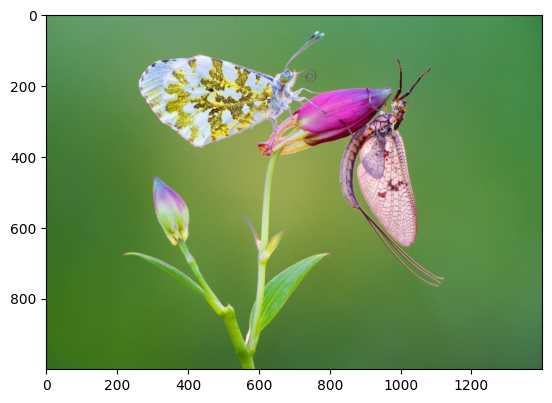

image loaded.



Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-7-7 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 322 layers, 86254162 parameters, 0 gradients
Adding AutoShape... 


weight '/content/drive/MyDrive/Animal-Detector/weights/yolov5x.pt' loaded.

2 or more 'Insecta' detected with specified confidence interval >= 0.1.

1 detected 'Insecta' with higher confidence interval = 0.79 selected.



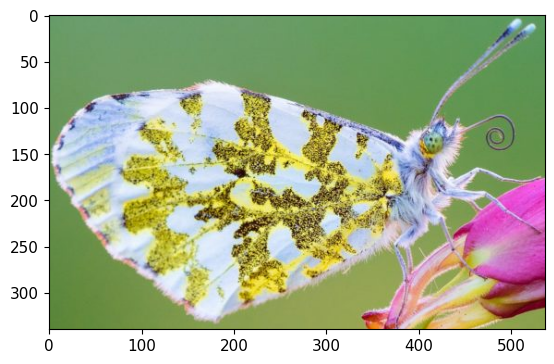

sample 0: [('bassinet', '0.2%'), ('airship, dirigible', '0.2%'), ('valley, vale', '0.1%'), ('Doberman, Doberman pinscher', '0.1%'), ('dhole, Cuon alpinus', '0.1%')]
output
['bassinet', 'airship, dirigible', 'valley, vale', 'Doberman, Doberman pinscher', 'dhole, Cuon alpinus']


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [8]:
# ================
# test - inference
# ================
output = infer(
    image=image, cls_custom="Insecta",
    weight_detector=weight_detector, weight_classifier=weight_classifier
)
output = [cls[0] for cls in output[0]]
print(f"output\n{output}")